In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.torch_geo_models import DotMLPRelu
from src.data.gamma.structural_arxiv import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.graph_sage import StructuralOmegaGraphSageDotMLP

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/03-1-structural_graphsage_dotmlp_gamma_function.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

In [7]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [8]:
data = prepare_adjencency(data)

## Training

In [12]:
for run in range(5):
    for n_layers_graph_sage in range(1, 3):
        for n_layers_mlp in range(1, 3):
            omega = StructuralOmegaGraphSageDotMLP(
                device,
                n_layers_graph_sage=n_layers_graph_sage,
                n_layers_mlp=n_layers_mlp,
                run=run)
            torch.cuda.empty_cache()
            omega.train(edges_train,
                        edges_val,
                        edges_test,
                        data.x,
                        data.y,
                        data.adj_t)

KeyboardInterrupt: 

## Results

### For a Layer Number

In [34]:
n_layers_graph_sage = 1
n_layers_mlp = 1

In [35]:
metrics = StructuralOmegaGraphSageDotMLP.read_metrics(
    n_layers_graph_sage=n_layers_graph_sage,
    n_layers_mlp=n_layers_mlp)
print(metrics.shape)
metrics.head()

(52, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.684818,0.687813,0.688010,0.502668,0.437679,0.444831
1,0,0,0.713057,0.708858,0.708096,0.469359,0.500446,0.500042
2,0,100,0.526478,0.552285,0.580372,0.760309,0.754943,0.721109
3,0,200,0.502151,0.530272,0.562148,0.790396,0.783012,0.751652
4,0,300,0.491951,0.525102,0.558615,0.802322,0.788592,0.757218


### Sumarize metrics per epoch

In [36]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [37]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [38]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.698937,0.019968,0.698335,0.014881,0.698053,0.014203,0.486014,0.023553,0.469062,0.044383,0.472436,0.03904
100,0.526478,NaN,0.552285,NaN,0.580372,NaN,0.760309,NaN,0.754943,NaN,0.721109,NaN
200,0.502151,NaN,0.530272,NaN,0.562148,NaN,0.790396,NaN,0.783012,NaN,0.751652,NaN
300,0.491951,NaN,0.525102,NaN,0.558615,NaN,0.802322,NaN,0.788592,NaN,0.757218,NaN
400,0.484327,NaN,0.521241,NaN,0.555724,NaN,0.810292,NaN,0.793186,NaN,0.761825,NaN


In [39]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
1400,0.448156,NaN,0.516204,NaN,0.554713,NaN,0.843795,NaN,0.801230,NaN,0.770002,NaN
1700,0.441717,NaN,0.518398,NaN,0.558127,NaN,0.849173,NaN,0.801014,NaN,0.769632,NaN
1800,0.439526,NaN,0.519028,NaN,0.559025,NaN,0.850941,NaN,0.800976,NaN,0.769608,NaN
1500,0.445686,NaN,0.517475,NaN,0.556528,NaN,0.845926,NaN,0.800954,NaN,0.769676,NaN
1900,0.437327,NaN,0.519645,NaN,0.559949,NaN,0.852701,NaN,0.800936,NaN,0.769557,NaN


/tmp/ipykernel_15490/1759826237.py:29: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_15490/1759826237.py:77: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



Text(0, 0.5, 'ROC AUC')

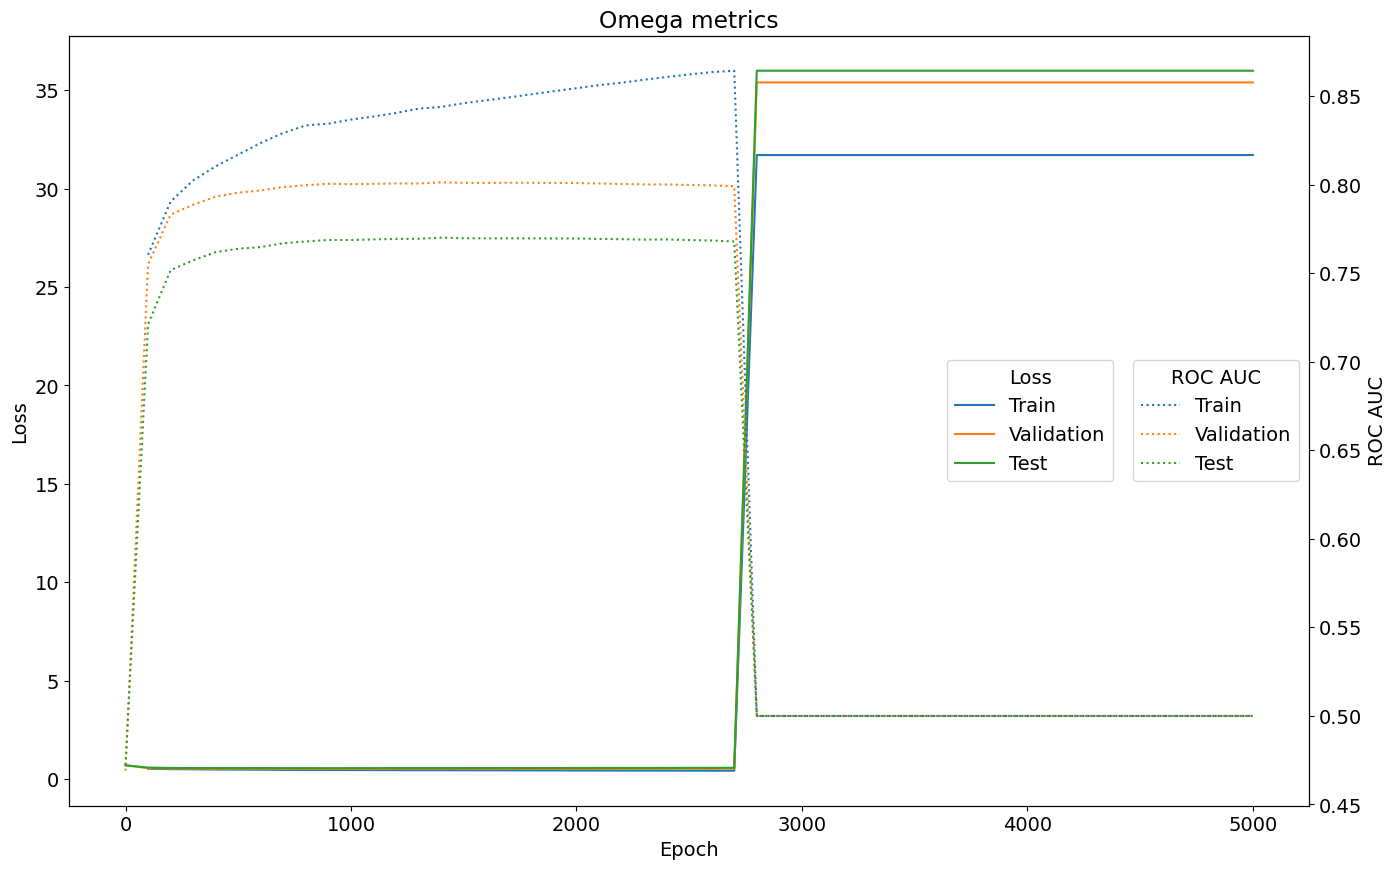

In [40]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

# ax1.errorbar(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.plot(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    # yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.plot(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    # yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.plot(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    # yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

# ax2.errorbar(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.errorbar(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.plot(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    # yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.plot(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    # yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.plot(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    # yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

# plt.savefig(f'reports/images/structural_omega_dotmlp_training_metrics_{n_layers}layers.pdf')

### Comparing Validation Performance for All Layer numbers

In [30]:
n_layers_list = range(1, 6)

In [43]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers in n_layers_list:
    metrics = StructuralOmegaGraphSageDotMLP.read_metrics(n_layers=n_layers)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers] = auc_val
    mean_loss_val_dict[n_layers] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers] = auc_val
    std_loss_val_dict[n_layers] = loss_val

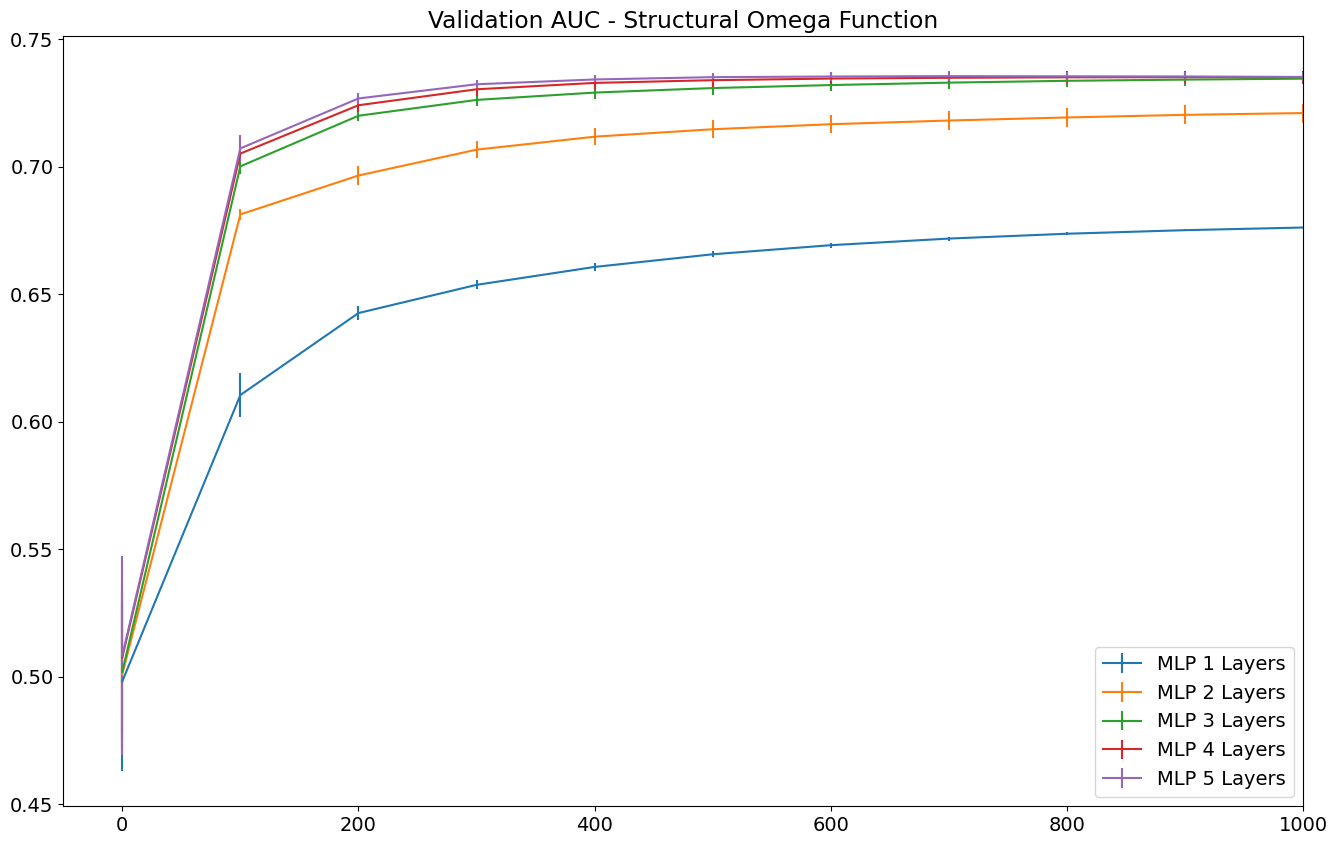

In [51]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'MLP {n_layers} Layers')

ax1.set_xlim(-50, 1000)

ax1.legend()